3. Compare o desempenho obtido considerando diferentes linguages. Por exemplo, indicando qual das linguagens tiram melhor partido do PowerCap.

Analizar a relação Package(PowerConsumption+Memory) e Time (Execution Time) em cada PowerLimit. As que tem melhor relação (Power Consumption Baixo e Execution Time Baixo) são melhores.

In [70]:
import seaborn as sea
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import numpy as py
from sklearn.neighbors import KernelDensity
from scipy.stats import anderson
from scipy.cluster.hierarchy import dendrogram,linkage
from sklearn.cluster import KMeans
from matplotlib.lines import Line2D
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

      Program  PowerLimit     Package        Core   Time  Temperature  Memory
0   chameleon          -1  416.231750  369.447876  17751         53.6   43820
1   chameleon          -1  406.150635  362.666504  17516         54.0   43780
2   chameleon          -1  403.458496  360.269714  17474         53.6   43796
3   chameleon          -1  406.172363  362.136658  17466         52.4   43532
4   chameleon          -1  404.590515  363.036011  17408         53.3   43700


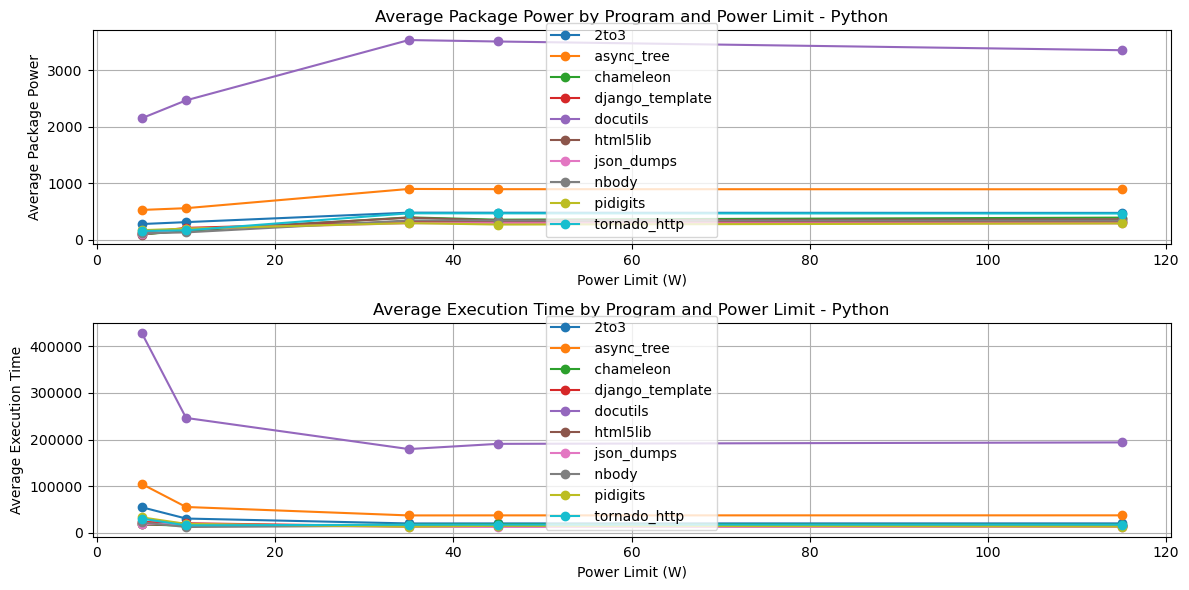

In [71]:
# Load the data from the CSV file
data_Python = pd.read_csv('measurements_python.csv')

# Display the first few rows of the Data_Pythondata_PythonFrame

data_Python = data_Python.drop(['Language','DRAM', 'GPU'], axis=1)
print(data_Python.head())
# Ensure the 'Package' and 'Time' columns are numeric, converting any non-numeric values to NaN
#data_Python['Package'] = pd.to_numeric(data_Python['Package'], errors='coerce')
data_Python['PowerLimit'] = pd.to_numeric(data_Python['PowerLimit'], errors='coerce')
data_Python['Time'] = pd.to_numeric(data_Python['Time'], errors='coerce')

# Drop rows with NaN values in 'Package', 'Program', 'PowerLimit', or 'Time' columns
data_Python = data_Python.dropna(subset=[ 'Program', 'PowerLimit', 'Time'])

# Remove potential duplicates
data_Python = data_Python.drop_duplicates()

data_Python = data_Python[data_Python['PowerLimit'] != -1]
data_Python = data_Python[data_Python['Core'] > 0]
data_Python = data_Python[data_Python['Package'] > 0]

# Ensure that 'Program' is treated as a categorical variable
data_Python['Program'] = data_Python['Program'].astype('category')

# Group by 'Program' and 'PowerLimit' and calculate the mean package power and mean execution time
grouped_data_Python = data_Python.groupby(['Program', 'PowerLimit']).agg({
    'Package': 'mean',
    'Time': 'mean'
}).reset_index()

# Plotting the data_Python
plt.figure(figsize=(12, 6))

# Plot average package power by program and power limit
plt.subplot(2, 1, 1)
for program in grouped_data_Python['Program'].unique():
    subset = grouped_data_Python[grouped_data_Python['Program'] == program]
    plt.plot(subset['PowerLimit'], subset['Package'], label=program, marker='o')

plt.title('Average Package Power by Program and Power Limit - Python')
plt.xlabel('Power Limit (W)')
plt.ylabel('Average Package Power')
plt.legend()
plt.grid(True)

# Plot average execution time by program and power limit
plt.subplot(2, 1, 2)
for program in grouped_data_Python['Program'].unique():
    subset = grouped_data_Python[grouped_data_Python['Program'] == program]
    plt.plot(subset['PowerLimit'], subset['Time'], label=program, marker='o')

plt.title('Average Execution Time by Program and Power Limit - Python')
plt.xlabel('Power Limit (W)')
plt.ylabel('Average Execution Time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [72]:
data_Python.head()

,Program,PowerLimit,Package,Core,Time,Temperature,Memory
100,chameleon,5,94.131226,45.947815,18805,38.5,43464
101,chameleon,5,91.207153,46.181702,18255,39.0,43756
102,chameleon,5,91.568359,46.093201,18307,38.8,43796
103,chameleon,5,92.209900,46.148071,18443,38.9,43756
104,chameleon,5,90.719482,45.988159,18140,39.5,43844


In [73]:
# REMOVE OUTLIERS IN EACH POWERLIMIT GROUP FOR EACH PROGRAM

grouped_df = data_Python.groupby(['Program', 'PowerLimit'])
def remove_outliers(group):
    # Remove outliers from 'Time' column
    Q1_time = group['Time'].quantile(0.25)
    Q3_time = group['Time'].quantile(0.75)
    IQR_time = Q3_time - Q1_time
    mask_time = (group['Time'] >= (Q1_time - 1.5 * IQR_time)) & (group['Time'] <= (Q3_time + 1.5 * IQR_time))

    # Remove outliers from 'Package' column
    Q1_package = group['Package'].quantile(0.25)
    Q3_package = group['Package'].quantile(0.75)
    IQR_package = Q3_package - Q1_package
    mask_package = (group['Package'] >= (Q1_package - 1.5 * IQR_package)) & (group['Package'] <= (Q3_package + 1.5 * IQR_package))

    # Combine the masks for both columns
    mask = mask_time & mask_package

    return group[mask]


cleaned_df = grouped_df.apply(remove_outliers).reset_index(drop=True)
print(cleaned_df.groupby(['Program','PowerLimit']).count())


                             Package  Core  Time  Temperature  Memory
Program          PowerLimit                                          
 2to3            5                 9     9     9            9       9
                 10                7     7     7            7       7
                 35               10    10    10           10      10
                 45               10    10    10           10      10
                 115              10    10    10           10      10
 async_tree      5                10    10    10           10      10
                 10               10    10    10           10      10
                 35                8     8     8            8       8
                 45                9     9     9            9       9
                 115               9     9     9            9       9
 chameleon       5                 8     8     8            8       8
                 10                9     9     9            9       9
                 35 

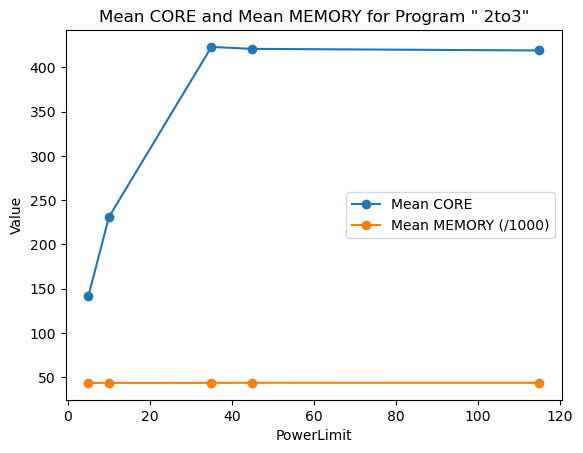

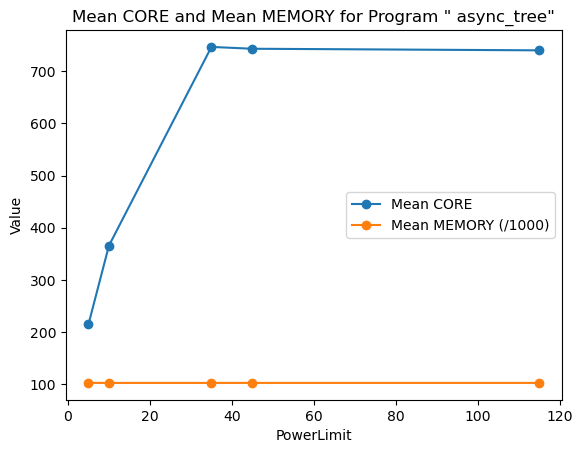

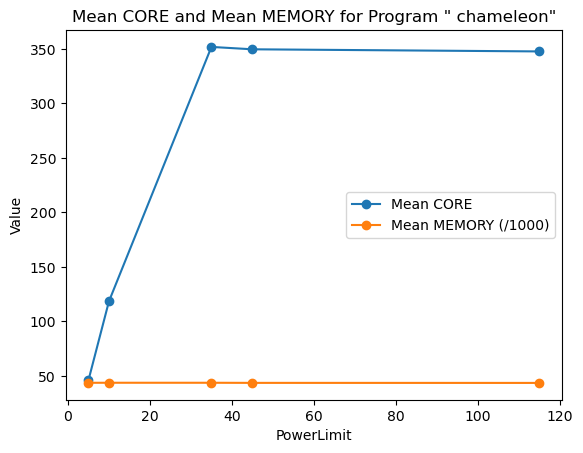

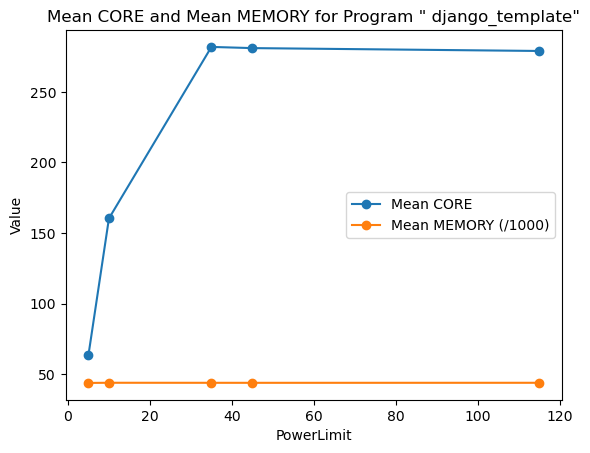

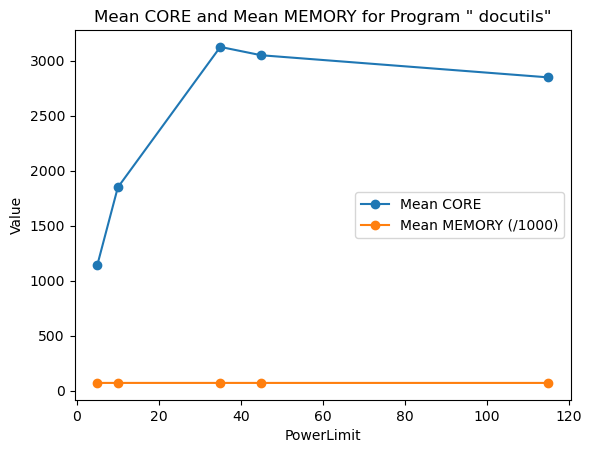

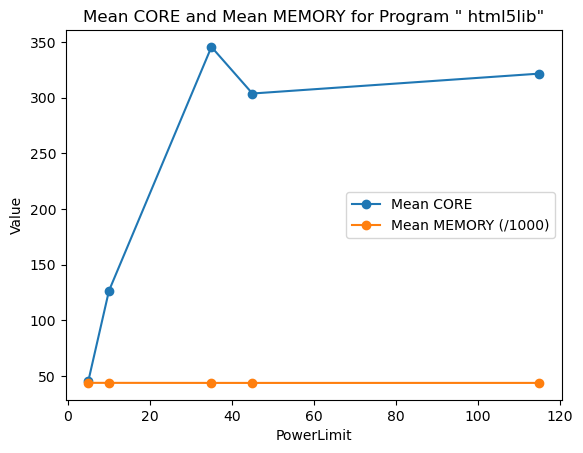

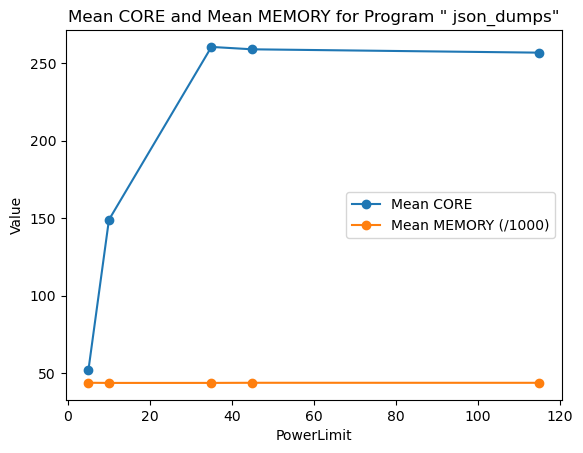

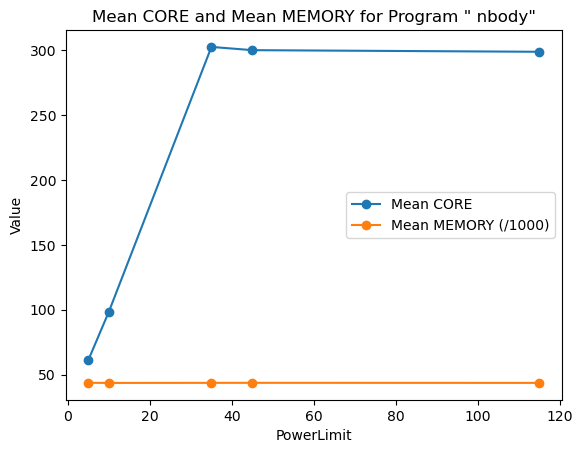

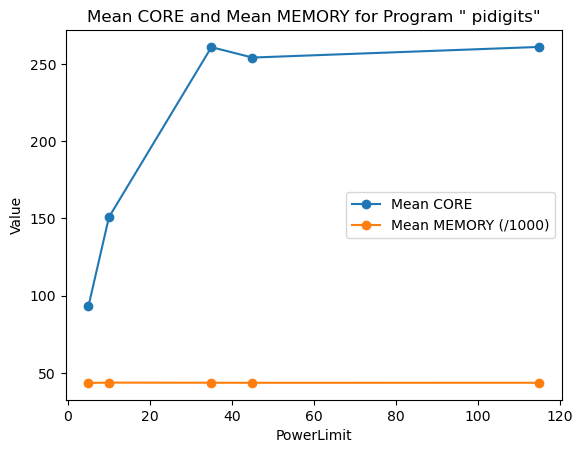

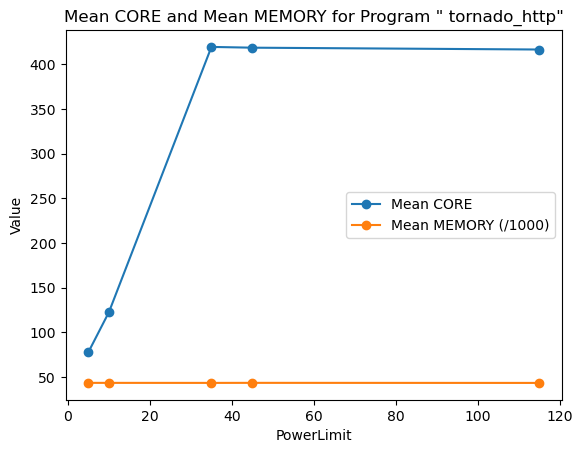

In [74]:
grouped = cleaned_df.groupby('Program')

def show_plot_Core_Memory(name, program_group):
    # Group the program group by PowerLimit
    power_groups = program_group.groupby('PowerLimit')

    # Create an empty list to store the data for each PowerLimit
    mean_core = []
    mean_memory = []

    # Extract data for each PowerLimit and store it in the list
    for power, power_group in power_groups:
        mean_core.append(power_group['Core'].mean())
        mean_memory.append(power_group['Memory'].mean()/1000)

    # Create a new figure for each program
    plt.figure()

    # Plot the mean CORE and mean MEMORY against PowerLimit
    plt.plot(power_groups.groups.keys(), mean_core, 'o-', label='Mean CORE')
    plt.plot(power_groups.groups.keys(), mean_memory, 'o-', label='Mean MEMORY (/1000)')

    # Set labels and title
    plt.xlabel('PowerLimit')
    plt.ylabel('Value')
    plt.title(f'Mean CORE and Mean MEMORY for Program "{name}"')
    plt.legend()

    # Show the plot
    plt.show()

# Apply the show_plot function to each group
for name, program_group in grouped:
    show_plot_Core_Memory(name, program_group)

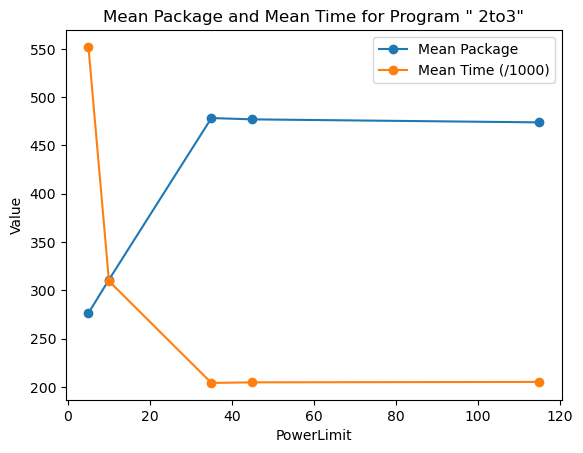

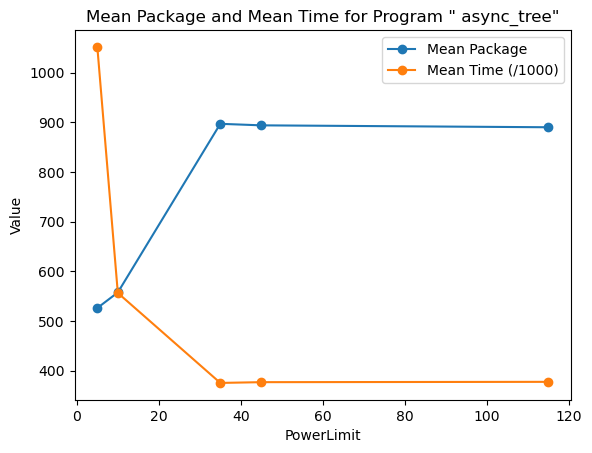

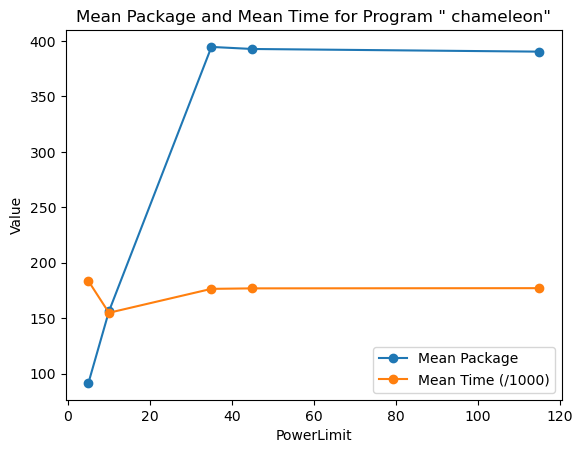

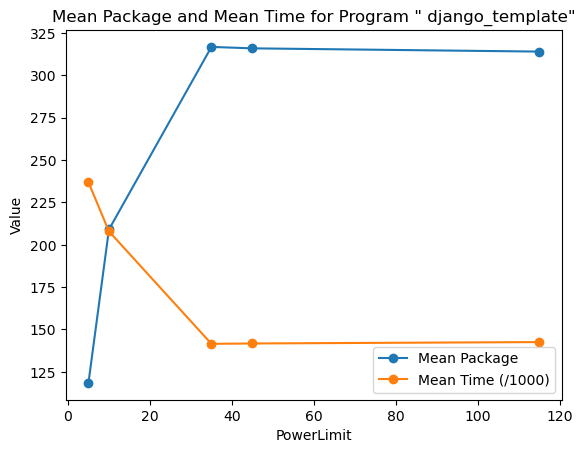

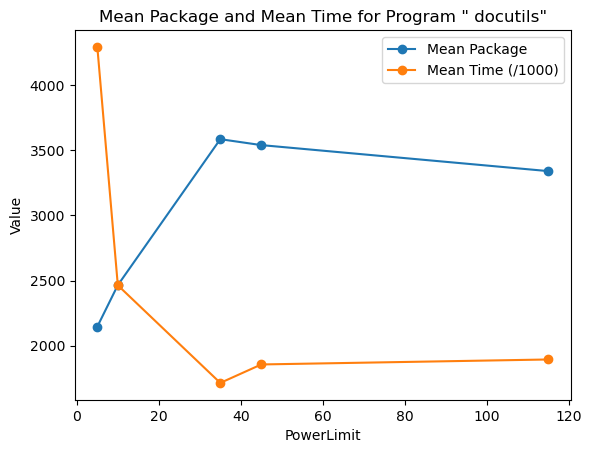

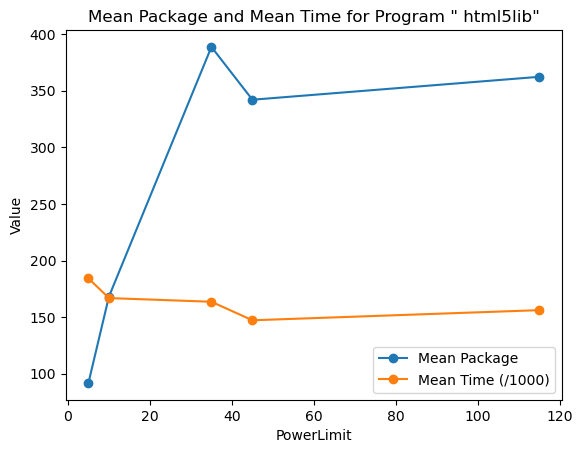

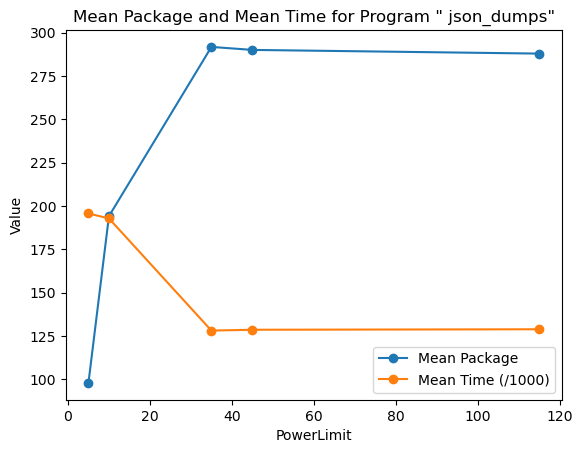

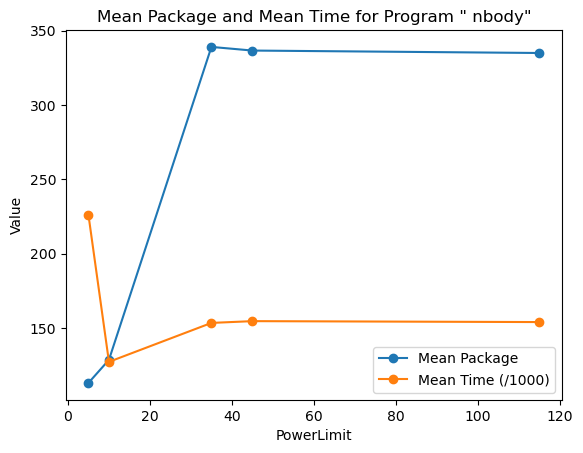

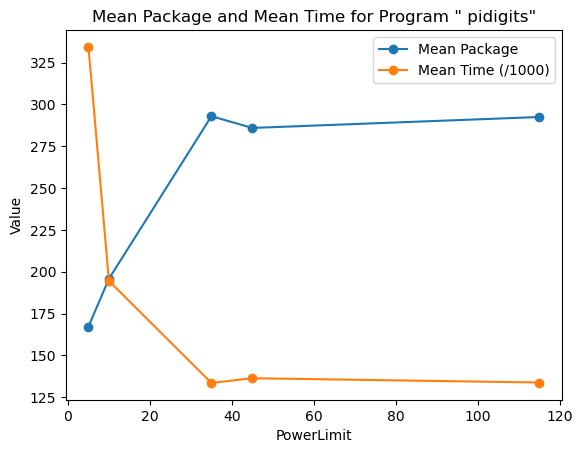

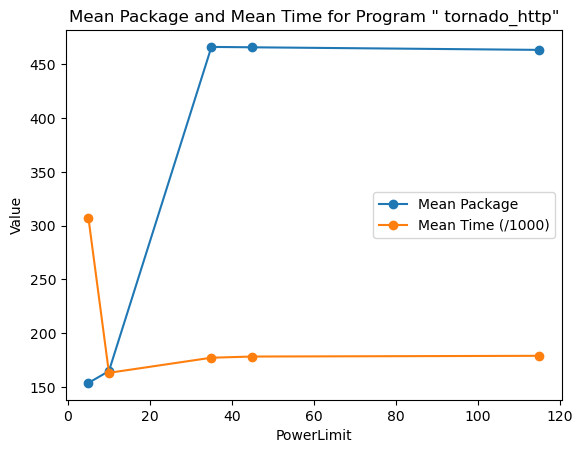

In [75]:
def show_plot_Package_Time(name, program_group):
    # Group the program group by PowerLimit
    power_groups = program_group.groupby('PowerLimit')

    # Create an empty list to store the data for each PowerLimit
    mean_package = []
    mean_time = []

    # Extract data for each PowerLimit and store it in the list
    for power, power_group in power_groups:
        mean_package.append(power_group['Package'].mean())
        mean_time.append(power_group['Time'].mean()/100)

    # Create a new figure for each program
    plt.figure()

    # Plot the mean CORE and mean MEMORY against PowerLimit
    plt.plot(power_groups.groups.keys(), mean_package, 'o-', label='Mean Package')
    plt.plot(power_groups.groups.keys(), mean_time, 'o-', label='Mean Time (/1000)')

    # Set labels and title
    plt.xlabel('PowerLimit')
    plt.ylabel('Value')
    plt.title(f'Mean Package and Mean Time for Program "{name}"')
    plt.legend()

    # Show the plot
    plt.show()

# Apply the show_plot function to each group
for name, program_group in grouped:
    show_plot_Package_Time(name, program_group)

In [76]:
def show_stats(name, program_group):
    # Calculate the correlation coefficient between Time and Package
    corr_coef, p_value = stats.pearsonr(program_group['Time'], program_group['Package'])
    print(f"Program: {name}")
    print(f"Correlation coefficient between Time and Package: {corr_coef:.3f}")
    print(f"P-value: {p_value:.5f}")

    # Perform linear regression between Time and Package
    slope, intercept, r_value, p_value, std_err = stats.linregress(program_group['Package'], program_group['Time'])
    print(f"Linear regression results:")
    print(f"Slope: {slope:.3f}")
    print(f"Intercept: {intercept:.3f}")
    print(f"R-squared: {r_value**2:.3f}")
    print(f"P-value: {p_value:.5f}")
    print(f"Standard error: {std_err:.3f}")
    print("-" * 30)

# Apply the show_stats function to each group
for name, program_group in grouped:
    show_stats(name, program_group)

Program:  2to3
Correlation coefficient between Time and Package: -0.905
P-value: 0.00000
Linear regression results:
Slope: -137.829
Intercept: 85650.720
R-squared: 0.819
P-value: 0.00000
Standard error: 9.769
------------------------------
Program:  async_tree
Correlation coefficient between Time and Package: -0.827
P-value: 0.00000
Linear regression results:
Slope: -126.598
Intercept: 149989.728
R-squared: 0.683
P-value: 0.00000
Standard error: 12.999
------------------------------
Program:  chameleon
Correlation coefficient between Time and Package: 0.275
P-value: 0.07044
Linear regression results:
Slope: 2.060
Intercept: 16757.820
R-squared: 0.076
P-value: 0.07044
Standard error: 1.110
------------------------------
Program:  django_template
Correlation coefficient between Time and Package: -0.988
P-value: 0.00000
Linear regression results:
Slope: -50.054
Intercept: 30192.030
R-squared: 0.976
P-value: 0.00000
Standard error: 1.207
------------------------------
Program:  docutils
Co

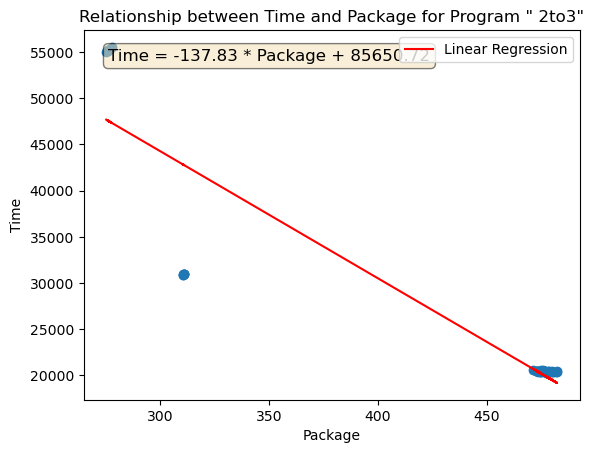

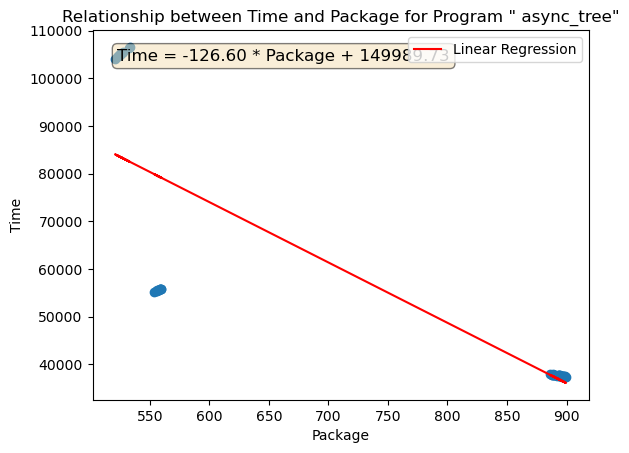

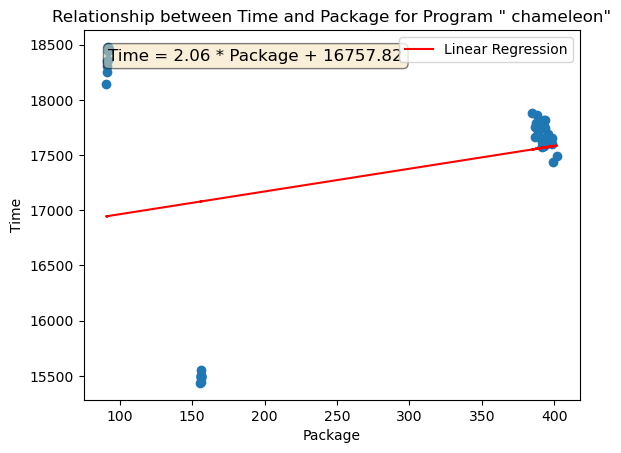

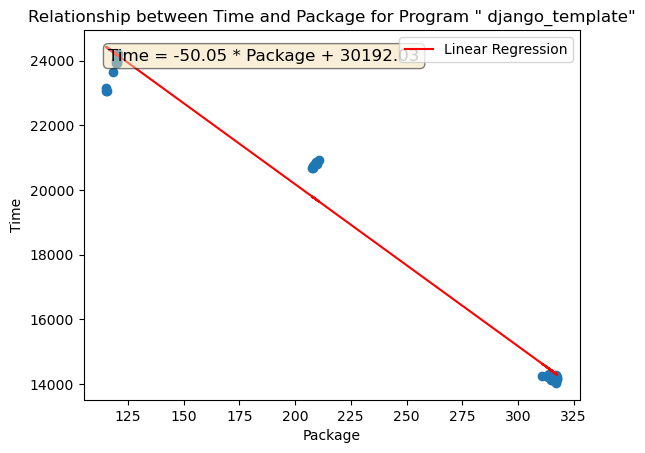

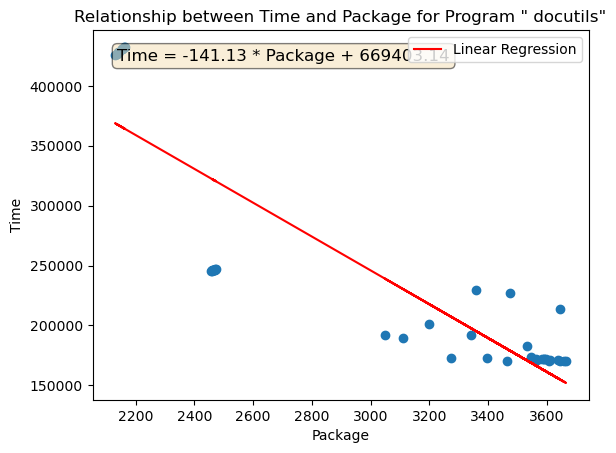

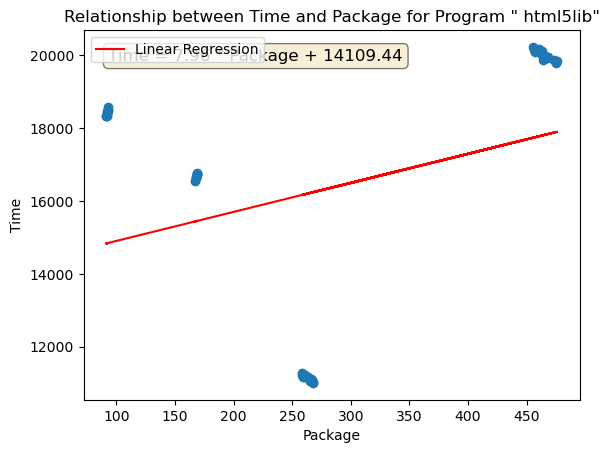

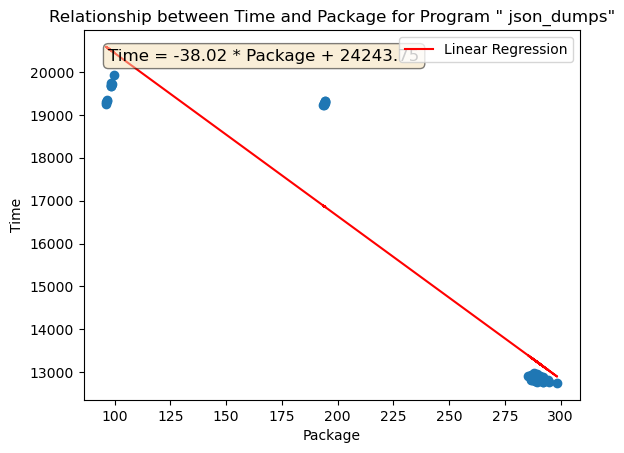

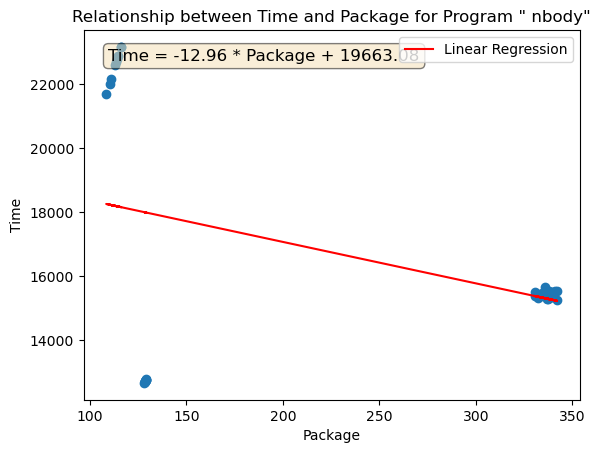

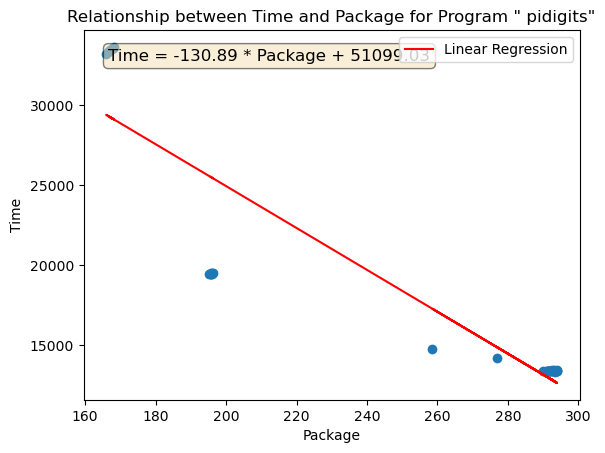

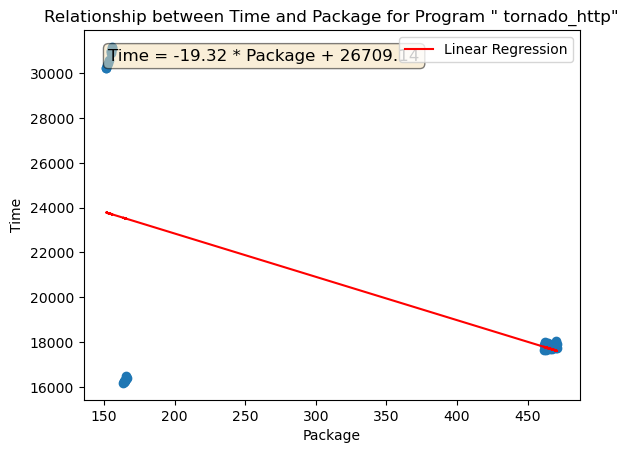

In [77]:
def show_scatter_plot(name, program_group):
    # Create a new figure for each program
    plt.figure()

    # Create a scatter plot of Time vs Package
    plt.scatter(program_group['Package'], program_group['Time'])

    # Perform linear regression between Time and Package
    slope, intercept, _, _, _ = stats.linregress(program_group['Package'], program_group['Time'])

    # Calculate the regression line
    x_values = program_group['Package']
    y_values = slope * x_values + intercept

    # Plot the regression line
    plt.plot(x_values, y_values, 'r', label='Linear Regression')

    # Display the regression equation
    equation = f'Time = {slope:.2f} * Package + {intercept:.2f}'
    plt.text(0.05, 0.95, equation, transform=plt.gca().transAxes, fontsize=12,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # Set labels and title
    plt.xlabel('Package')
    plt.ylabel('Time')
    plt.title(f'Relationship between Time and Package for Program "{name}"')
    plt.legend()

    # Show the plot
    plt.show()

# Apply the show_scatter_plot function to each group
for name, program_group in grouped:
    show_scatter_plot(name, program_group)


In [78]:
regression_equations = {}
slope_vals = []
intercept_vals = []

for name, program_group in grouped:
    slope, intercept, _, _, _ = stats.linregress(program_group['Package'], program_group['Time'])
    slope_vals.append(slope)
    intercept_vals.append(intercept)
    equation = f'Time = {slope:.2f} * Package + {intercept:.2f}'
    regression_equations[name] = equation

# Print the regression equations
for program, equation in regression_equations.items():
    print(f"Program: {program}")
    print(f"Regression equation: {equation}")
    print("-" * 30)

print("Average slope:", py.mean(slope_vals))
print("Average intercept:", py.mean(intercept_vals))

Program:  2to3
Regression equation: Time = -137.83 * Package + 85650.72
------------------------------
Program:  async_tree
Regression equation: Time = -126.60 * Package + 149989.73
------------------------------
Program:  chameleon
Regression equation: Time = 2.06 * Package + 16757.82
------------------------------
Program:  django_template
Regression equation: Time = -50.05 * Package + 30192.03
------------------------------
Program:  docutils
Regression equation: Time = -141.13 * Package + 669403.14
------------------------------
Program:  html5lib
Regression equation: Time = 7.96 * Package + 14109.44
------------------------------
Program:  json_dumps
Regression equation: Time = -38.02 * Package + 24243.75
------------------------------
Program:  nbody
Regression equation: Time = -12.96 * Package + 19663.08
------------------------------
Program:  pidigits
Regression equation: Time = -130.89 * Package + 51099.03
------------------------------
Program:  tornado_http
Regression equat

In [79]:
package_range = range(4, 7)

for program, equation in regression_equations.items():
    print(f"Program: {program}")
    for package in package_range:
        slope, intercept = equation.split(' = ')[1].split(' * Package + ')
        slope = float(slope)
        intercept = float(intercept)
        time = slope * package + intercept
        print(f"Package: {package}, Time: {time:.2f}")
    print("-" * 30)

Program:  2to3
Package: 4, Time: 85099.40
Package: 5, Time: 84961.57
Package: 6, Time: 84823.74
------------------------------
Program:  async_tree
Package: 4, Time: 149483.33
Package: 5, Time: 149356.73
Package: 6, Time: 149230.13
------------------------------
Program:  chameleon
Package: 4, Time: 16766.06
Package: 5, Time: 16768.12
Package: 6, Time: 16770.18
------------------------------
Program:  django_template
Package: 4, Time: 29991.83
Package: 5, Time: 29941.78
Package: 6, Time: 29891.73
------------------------------
Program:  docutils
Package: 4, Time: 668838.62
Package: 5, Time: 668697.49
Package: 6, Time: 668556.36
------------------------------
Program:  html5lib
Package: 4, Time: 14141.28
Package: 5, Time: 14149.24
Package: 6, Time: 14157.20
------------------------------
Program:  json_dumps
Package: 4, Time: 24091.67
Package: 5, Time: 24053.65
Package: 6, Time: 24015.63
------------------------------
Program:  nbody
Package: 4, Time: 19611.24
Package: 5, Time: 19598.28

In [80]:
# Define a range of Package values to evaluate
package_range = range(4, 4700)

# Define weights for Time and Package
time_weight = 0.5
package_weight = 0.5

best_score = float('inf')
best_program = None
overall_scores = []

for program, equation in regression_equations.items():
    total_score = 0
    for package in package_range:
        slope, intercept = equation.split(' = ')[1].split(' * Package + ')
        slope = float(slope)
        intercept = float(intercept)
        time = max(slope * package + intercept, 0)
        score = time_weight * time + package_weight * package
        total_score += score
    
    average_score = total_score / len(package_range)
    overall_scores.append(average_score)
    
    if average_score < best_score:
        best_score = average_score
        best_program = program

    
    
    print(f"Program: {program}")
    print(f"Equation: {equation}")
    print(f"Average score: {average_score:.2f}")
    print("-" * 30)

print(f"The best program is: {best_program}")

overall_average_score = sum(overall_scores) / len(overall_scores)
print(f"\nOverall average score of Python Language: {overall_average_score:.2f}")

Program:  2to3
Equation: Time = -137.83 * Package + 85650.72
Average score: 3977.47
------------------------------
Program:  async_tree
Equation: Time = -126.60 * Package + 149989.73
Average score: 10580.16
------------------------------
Program:  chameleon
Equation: Time = 2.06 * Package + 16757.82
Average score: 11976.70
------------------------------
Program:  django_template
Equation: Time = -50.05 * Package + 30192.03
Average score: 2134.13
------------------------------
Program:  docutils
Equation: Time = -141.13 * Package + 669403.14
Average score: 169943.72
------------------------------
Program:  html5lib
Equation: Time = 7.96 * Package + 14109.44
Average score: 17589.44
------------------------------
Program:  json_dumps
Equation: Time = -38.02 * Package + 24243.75
Average score: 1989.74
------------------------------
Program:  nbody
Equation: Time = -12.96 * Package + 19663.08
Average score: 2756.65
------------------------------
Program:  pidigits
Equation: Time = -130.89 *

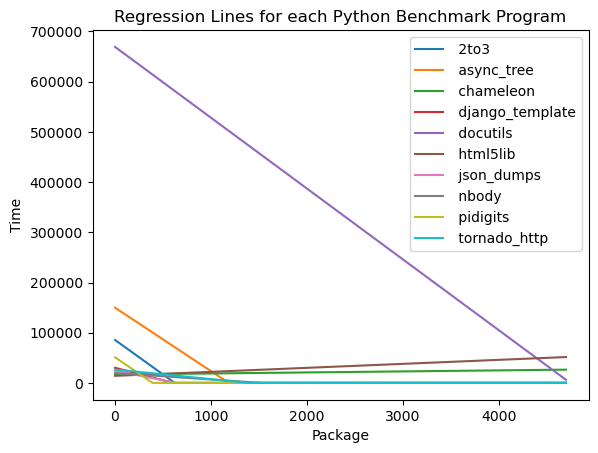

In [81]:
regression_equations = {}

# Create a figure and axis objects
fig, ax = plt.subplots()

# Define a range of Package values to evaluate
package_range = range(1, 4700)

for name, program_group in grouped:
    slope, intercept, _, _, _ = stats.linregress(program_group['Package'], program_group['Time'])
    equation = f'Time = {slope:.2f} * Package + {intercept:.2f}'
    regression_equations[name] = equation

    # Calculate the regression line
    x_values = package_range
    y_values = [max(slope * x + intercept, 0) for x in x_values]

    # Plot the regression line
    ax.plot(x_values, y_values, label=name)

# Set labels, title, and legend
ax.set_xlabel('Package')
ax.set_ylabel('Time')
ax.set_title('Regression Lines for each Python Benchmark Program')
ax.legend()

# Show the plot
plt.show()

## Conclusion

In some benchamarks, Python shows a bad improvement in Execution Time when Powercap is increased. This means that per unit of powercap changed, there's no to inverse diference in time. Statistically we can predict time with a linear regression equation , Time = slope * Package + intercept. 

The average slope and intercept across benchmarks is :

    - Average slope: -64.67766579797102
    - Average intercept: 108781.78929216231
  
The team created a custom score which takes into acount Time values and Package values, meaning the higher score the worst it is. 

The average score for haskell between 1-4700 in package values is 22629.84. 
